<h3><u>a- Proximal operator</u><h3>

In [252]:
import numpy as np
import statistics
import utils
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import copy

def soft_thresholding(x, lambd):
    """Element-wise soft-thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - lambd, 0)

def proximal_operator_smooth_lasso(v, gamma, L, kappa, m):
    """
    Proximal operator for the smooth-lasso with FISTA.
    
    Args:
    v (numpy.array): Spatial map v.
    gamma (float): Regularization parameter.
    L (numpy.array): Matrix corresponding to the operator L in the regularization.
    kappa (float): Step size parameter.
    k (int): Number of iterations.
    
    Returns:
    numpy.array: Denoised map v*.
    """
    v_star = v.copy()
    z = v_star.copy()
    tau = 1
    
    for l in range(m):
        v0 = v_star.copy()
        # Soft-thresholding operation
        v_star = soft_thresholding(z - kappa * (z - v + gamma * L @ z), kappa * gamma)
        tau_0 = tau
        tau = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
        z = v_star + ((tau_0 - 1) / tau) * (v_star - v0)
    
    return v_star



<h3><u>b- Optimization</u><h3>

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_44880/2882625393.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


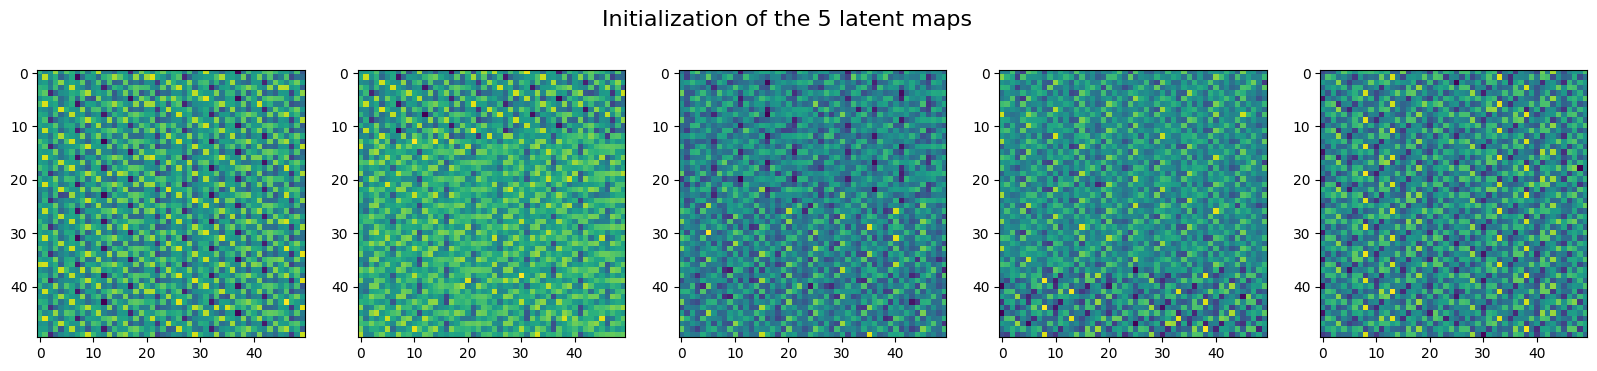

In [263]:
def get_init_V(data_fmri: np.ndarray, n_components: int) -> np.ndarray:
    S, n, p1, _ = data_fmri.shape
    p = p1 ** 2
    X = data_fmri.reshape(p, S*n)
    transformer = FastICA(n_components=n_components, random_state=0, whiten='unit-variance')
    X_transformed = transformer.fit_transform(X)
    X_transformed = X_transformed.reshape(n_components, p1,p1)# need to be size ( n_components,p1,p1)
    return X_transformed

def plot_latent_maps(V: np.ndarray) -> None:
    k = V.shape[0]
    fig, ax = plt.subplots(1, k, figsize=(20, 4))
    fig.suptitle(f'Initialization of the {k} latent maps', fontsize=16)
    for i in range(k):
        ax[i].imshow(V[i, :,:])
    fig.show()

def read_fmri(path: str) -> np.ndarray:
    data_fmri = numpy.load(path)
    S,n,_,_ =data_fmri.shape
    Ys = data_fmri.reshape(S, n, -1) # need to be of (S,n,p)
    return Ys

n_components = 5
V = get_init_V(data_fmri,n_components)

plot_latent_maps(V)
Ys = read_fmri("synthetic_data.npy")


In [261]:
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

class MDSLModel:
    def __init__(self, grid_size: int = 50, k: int = 5, mu: float = 0.1, lambd: float= 0.1) -> None:
        self.grid_size = grid_size
        self.L = MDSLModel.create_2d_laplacian(grid_size)
        self.k = k 
        self.mu = mu
        self.lambd = lambd

    @staticmethod
    def create_2d_laplacian(grid_size: int):
        # Création de la matrice laplacienne pour une grille 1D
        e = np.ones(grid_size)
        laplacian_1d = np.diag(2 * np.ones(grid_size)) - np.diag(np.ones(grid_size - 1), k=1) - np.diag(np.ones(grid_size - 1), k=-1)
        
        # Création de la matrice laplacienne pour une grille 2D
        I = np.eye(grid_size)
        laplace_2d = np.kron(I, laplacian_1d) + np.kron(laplacian_1d, I)
        return laplace_2d
    
    def regularizer(self, V: np.ndarray):
        _, k = V.shape
        norm1_v = np.sum(np.abs(V))
        quadratic_term = 0
        for i in range(k):
            quadratic_term += 0.5 * (V[:, i].T @ self.L @ V[:, i])
        return norm1_v + quadratic_term

    def compute_energy(self, Ys, Us, Vs, V):
        S = len(Us)  # Number of subjects
        energy = 0
        for s in range(S):
            term1 = np.linalg.norm(Ys[s] - Us[s] @ Vs[s].T, 'fro')**2
            term2 = self.mu * np.linalg.norm(Vs[s] - V, 'fro')**2
            energy += 0.5 * (term1 + term2)
        regularization_term = self.regularizer(V)
        energy += self.lambd * regularization_term
        return energy

    def update_vs(self, V, us, ys):
        id_matrix = np.identity(us.shape[1])
        vs = V + (ys - us @ V.T).T @ us @ np.linalg.inv(us.T @ us + self.mu * id_matrix)
        return vs

    def update_us(self, ys, vs, us):
        for l in range(self.k):
            u_l, v_l = us[:, l], vs[:, l]
            u_l_new = u_l + np.linalg.norm(v_l, 2)**-2 * (ys - us @ vs.T) @ v_l
            us[:, l] = u_l_new / max(np.linalg.norm(u_l_new, 2), 1)
        return us
    
    @staticmethod
    def soft_thresholding(x, lambd):
        """Element-wise soft-thresholding operator."""
        return np.sign(x) * np.maximum(np.abs(x) - lambd, 0)
        
    def smooth_lasso_prox(self, v: np.ndarray, gamma: float, kappa: float, m: int = 100):
        v_star = copy.deepcopy(v)
        z = copy.deepcopy(v_star)
        tau = 1
        print(m)
        
        for l in range(m):
            v0 = v_star.copy()
            # Soft-thresholding operation
            v_star = MDSLModel.soft_thresholding(z - kappa * (z - v + gamma * self.L @ z), kappa * gamma)
            tau_0 = tau
            tau = (1 + np.sqrt(1 + 4 * tau ** 2)) / 2
            z = v_star + ((tau_0 - 1) / tau) * (v_star - v0)
        return v_star

    def __call__(self,
                 Ys: np.ndarray,
                 V: np.ndarray,
                 gamma: np.ndarray,
                 kappa: np.ndarray,
                 max_iter=1000,
                 tolerance: float =1e-4):
        """_summary_

        Args:
            Ys (np.ndarray): _description_
            V (np.ndarray): _description_
            gamma (np.ndarray): _description_
            kappa (np.ndarray): _description_
            max_iter (int, optional): _description_. Defaults to 1000.
            tolerance (float, optional): _description_. Defaults to 1e-4.

        Returns:
            _type_: _description_
        """
        n, p = Ys.shape[1:]  # n number of time points, p number of voxels 
        S = len(Ys)          # S number of subjects
        Vs = [np.random.rand(p, self.k) for _ in range(S)]  # Subject specific spatial maps
        Us = [np.random.rand(n, self.k) for _ in range(S)]  # Time series
        E_old = self.compute_energy(Ys, Us, Vs, V) * 2
        E_new = self.compute_energy(Ys, Us, Vs, V)

        i = 0  # Iteration counter
        while np.abs(E_new - E_old) > tolerance * E_old and i < max_iter:
            E_old = E_new
            # Update each U^s
            for s in range(S):
                Us[s] = self.update_us(Ys[s], Vs[s], Us[s])
                Vs[s] = self.update_vs(V, Us[s], Ys[s])

            Vs_mean = np.mean(Vs, axis=0)
            # Apply the proximal operator to the mean of every subject spatial maps
            for j in range(self.k):
                V[:, j] = self.smooth_lasso_prox(v = Vs_mean[:, j], gamma = gamma, kappa = kappa)
            
            # Compute the energy
            E_new = self.compute_energy(Ys, Us, Vs, V)
            i += 1
            print(f'Energy: {E_new}')
        
        return V, Vs, Us
        



In [262]:
model = MDSLModel()

model(Ys= Ys , V= V.reshape(2500,n_components), gamma= 0.1 , kappa=0.1, max_iter=1000,  tolerance=1e-4)

Iteration 0
100
100
100
100
100
Energy: 2086002.3246892062
Iteration 1
100
100
100
100
100
Energy: 741793.5680862392
Iteration 2
100
100
100
100
100
Energy: 585222.2707354921
Iteration 3
100
100
100
100
100
Energy: 494286.08321148506
Iteration 4
100
100
100
100
100
Energy: 451844.8608352899
Iteration 5
100
100
100
100
100
Energy: 425179.01784731285
Iteration 6
100
100
100
100
100
Energy: 406711.3011908142
Iteration 7
100
100
100
100
100
Energy: 391764.8537595841
Iteration 8
100
100
100
100
100
Energy: 378812.5060763535
Iteration 9
100
100
100
100
100
Energy: 368126.8195596211
Iteration 10
100
100
100
100
100
Energy: 359669.2269800929
Iteration 11
100
100
100
100
100
Energy: 352763.66736777587
Iteration 12
100
100
100
100
100
Energy: 346888.88010589324
Iteration 13
100
100
100
100
100
Energy: 341756.54629309115
Iteration 14
100
100
100
100
100
Energy: 337201.4086128439
Iteration 15
100
100
100
100
100
Energy: 333116.43163154036
Iteration 16
100
100
100
100
100
Energy: 329425.6420798112


KeyboardInterrupt: 

In [210]:
import statistics
import utils
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt


def create_2d_laplacian(grid_size):
    # Création de la matrice laplacienne pour une grille 1D
    e = np.ones(grid_size)
    laplacian_1d = np.diag(2 * np.ones(grid_size)) - np.diag(np.ones(grid_size - 1), k=1) - np.diag(np.ones(grid_size - 1), k=-1)
    
    # Création de la matrice laplacienne pour une grille 2D
    I = np.eye(grid_size)
    laplace_2d = np.kron(I, laplacian_1d) + np.kron(laplacian_1d, I)
    return laplace_2d


def omega(V, L):
    """
    returns omega(v) where v is a np array of size p1*p2
    """
    _, k = V.shape
    norm1_v = np.sum(np.abs(V))
    quadratic_term = 0
    for i in range(k):
        quadratic_term += 0.5 * (V[:,i].T @ L @ V[:,i])

    return norm1_v + quadratic_term

def get_init_V(data_fmri,k = 5):
    S, n, p1, _ = data_fmri.shape
    p = p1 ** 2
    X = data_fmri.reshape(p, S*n)
    transformer = FastICA(n_components=k, 
                        random_state=0,
                        whiten='unit-variance')
    X_transformed = transformer.fit_transform(X)
    X_transformed = X_transformed.reshape(p1, p1, k)
    return X_transformed


def compute_energy(Ys,Us,Vs,V,mu,lambda_r, L, regularization_fun = None, ):
    if regularization_fun is None :
        regularization_fun= lambda x : omega(x, L)
        
    S = len(Us)  # Number of subjects
    energy = 0
    for s in range(S):
        term1 = np.linalg.norm(Ys[s] - Us[s] @ Vs[s].T, 'fro')**2
        term2 = mu * np.linalg.norm(Vs[s] - V, 'fro')**2
        energy += 0.5 * (term1 + term2)
    
    regularizer = regularization_fun(V) 

    energy += lambda_r * regularizer
    
    return energy

def update_vs(V, us ,ys , mu):
    # Mettre à jour Vs en utilisant la régression ridge
    id = np.identity(us.shape[1])
    vs = V + (ys-us@V.T).T@ us@ np.linalg.inv(us.T@us + mu * id )
    return vs

def update_us(ys, vs, us):
    for l in range(k):
        u_l, v_l = us[:, l], vs[:, l]
        u_l_new = u_l + np.linalg.norm(v_l, 2)**-2 * (ys - us @ vs.T)@ v_l
        us[:, l] = u_l_new / max(np.linalg.norm(u_l_new, 2), 1)
    return us
    

def algorithm(Ys,V, k, mu, lambda_r, gamma, kappa, max_iter=1000, tolerance=1e-4):
    n,p = Ys.shape[1:] # n number of time points, p number of voxels 
    S = len(Ys)     # S number of subjects
    grid_size = int(np.sqrt(p))
    L = create_2d_laplacian(grid_size)
    
    # group level spatial maps
    Vs = [np.random.rand(p, k) for _ in range(S)]  # subject specific spatial maps
    Us = [np.random.rand(n, k) for _ in range(S)]  # time series
    E_old = compute_energy(Ys,Us,Vs,V,mu,lambda_r, L)*2
    E_new =  compute_energy(Ys,Us,Vs,V,mu,lambda_r, L)

    i = 0  # Iteration counter

    
    while np.abs(E_new - E_old) > tolerance * E_old and i < max_iter:
        print("hello")
        E_old = E_new
        # Update each U^s
        for s in range(S):
                Us[s] = update_us(Ys[s], Vs[s], Us[s])   
                Vs[s] = update_vs(V,Us[s],Ys[s],mu)
            
        Vs_mean = np.mean(Vs, axis=0)
        # Apply the proximal operator to the mean of every subject spatial maps
        for j in range(k):
            V[:,j]= proximal_operator_smooth_lasso(Vs_mean[:,j], gamma = gamma , L = L , kappa = kappa, m = 10)
        
        # Compute the energy
        E_new = compute_energy(Ys,Us,Vs,V,mu,lambda_r, L)
        i += 1
        print(f'Iteration {i}, Energy: {E_new}')
    
    return V,Vs,Us

/opt/homebrew/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_44880/3932720437.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


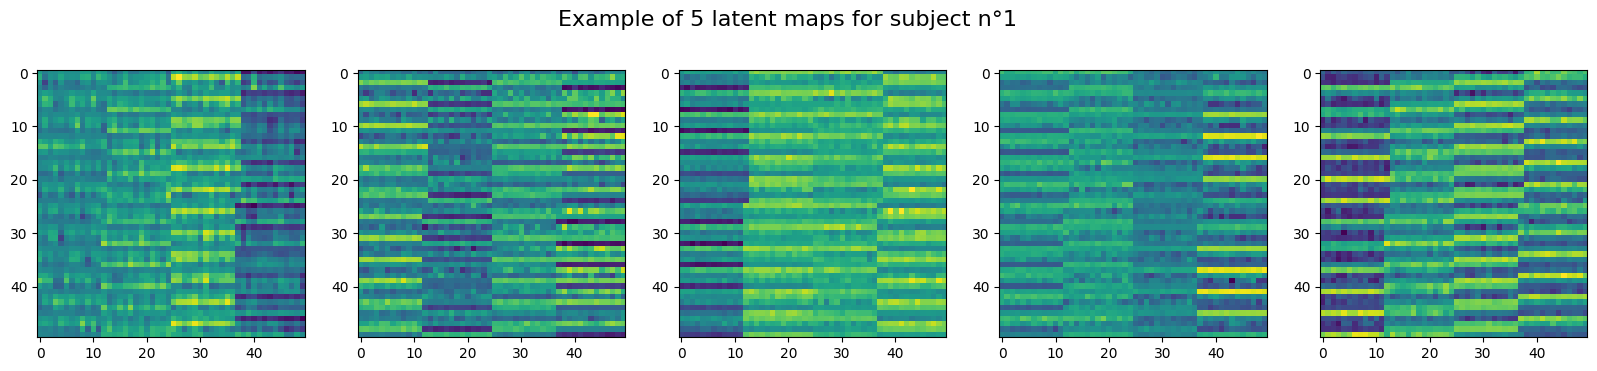

In [212]:
import numpy 
k = 5 

data_fmri = numpy.load('synthetic_data.npy')
S,n,_,_ =data_fmri.shape

Ys = data_fmri.reshape(S, n, -1)
Ys.shape

V = get_init_V(data_fmri, k )
V.shape
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Example of 5 latent maps for subject n°1',fontsize=16)
for i in range(k):
    ax[i].imshow(V.T[i, :,:])
fig.show()




In [213]:
mu = 0.1
k = 5



In [214]:
V = V.reshape(k,-1).T
print(V.shape)

(2500, 5)


In [215]:
V,Vs,Us= algorithm(Ys,V, k, mu, lambda_r = 0.2, gamma = 0.1, kappa = 0.1, max_iter=1400, tolerance=1e-4)





hello
Iteration 1, Energy: 2023226.2519083102
hello
Iteration 2, Energy: 900341.2288138394
hello
Iteration 3, Energy: 684568.3485601817
hello
Iteration 4, Energy: 544389.2294902579
hello
Iteration 5, Energy: 481903.1637945812
hello


KeyboardInterrupt: 

In [208]:
Vs = [Vs[i].reshape(5,50,50) for i in range(len(Vs))]
V = V.reshape(k,50,50)


/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_44880/3591932626.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


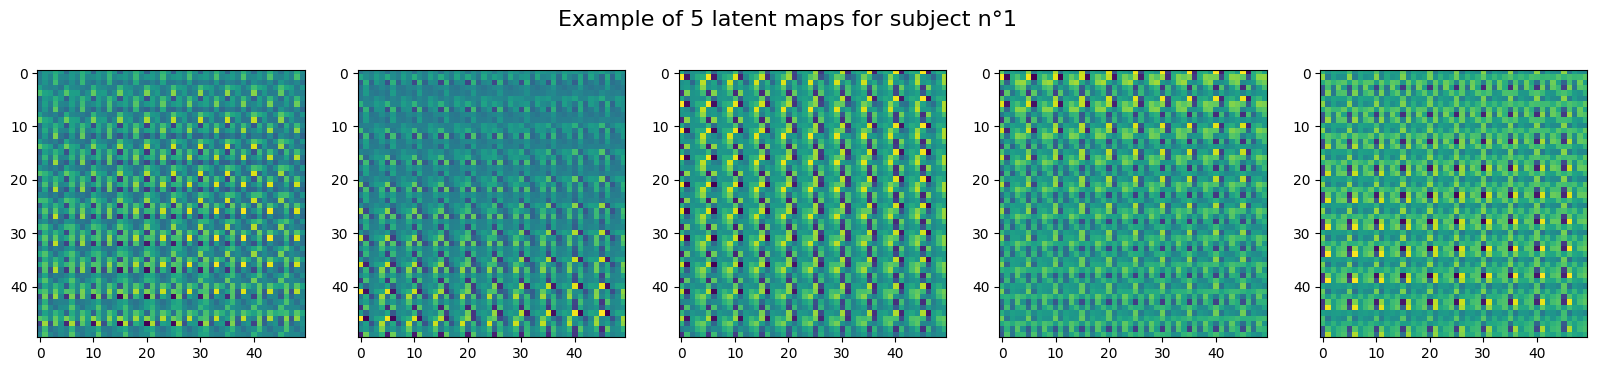

In [209]:
# Plotting the 5 latents maps generated 
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Example of 5 latent maps for subject n°1',fontsize=16)
for i in range(k):
    ax[i].imshow(V[i, :,:])
fig.show()
